# A Simulation Study of Negative Multinomial Estimators

In [1]:
import os
import subprocess

In [2]:
import matplotlib
%matplotlib nbagg
from matplotlib import pyplot

In [3]:
import math
from statiskit import (linalg,
                       core)

In [4]:
figure = os.environ.get('FIGURE', 'svg')
dimension = int(os.environ.get('DIMENSION', 5))
simulations = int(os.environ.get('SIMULATIONS', 10))
observations = int(os.environ.get('OBSERVATIONS', 100))
alpha = float(os.environ.get('ALPHA', 1.))

In [5]:
Kappa = core.GammaDistribution(alpha, 1.)
Pi = core.DirichletDistribution(dimension)

In [6]:
component = core.UnivariateDataFrame(core.controls.RR)
data = core.MultivariateDataFrame()
data.add_component(component)
data.add_component(component)
data.add_component(component)
data.add_component(component)
data.add_component(component)

In [7]:
while len(data.events) < observations:
    kappa = Kappa.simulate().value
    pi = linalg.Vector([pi.value for pi in Pi.simulate()])
    dist = core.MultinomialSplittingDistribution(core.NegativeBinomialDistribution(kappa,
                                                                                   sum(pi)),
                                                 pi)
    try:
        simdata = dist.simulation(observations)
        covariance = simdata.covariance
        if all(covariance[i,i] > 0. for i in range(dimension)):
            DBB12 = core.multinomial_splitting_estimation(data = simdata,
                                                           sum = core.negative_binomial_estimation())
            event = core.VectorEvent(5)
            event[0] = core.ContinuousElementaryEvent((kappa - DBB12.estimated.sum.kappa)/kappa)
            norm = 0.
            for i in range(dimension):
                norm += math.fabs(DBB12.estimated.sum.pi * DBB12.estimated.pi[i] - pi[i])
            event[1] = core.ContinuousElementaryEvent(norm)
            simdata.write_csv('data.csv')
            subprocess.call(['Rscript', 'simulation.R'])
            os.remove('data.csv')
            if os.path.exists('res.csv'):
                resdata = core.read_csv('res.csv')
                os.remove('res.csv')
                event[2] = core.ContinuousElementaryEvent((kappa - resdata.events[-1].value)/kappa)
                norm = 0.
                for i in range(dimension):
                    norm += math.fabs(resdata.events[i].value - pi[i])
                event[3] = core.ContinuousElementaryEvent(norm)
            event[4] = core.ContinuousElementaryEvent(kappa)
            data.add_event(event)
    except Exception as e:
        print e

<IPython.core.display.Javascript object>


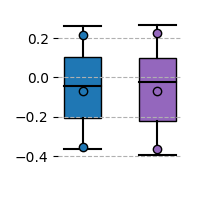

In [8]:
fig = pyplot.figure(figsize=(2,2))
axes = data.components[0].box_plot(axes = fig.add_subplot(111),
                                   pos = 0,
                                   extrema = False,
                                   color = 'b')
axes = data.components[2].box_plot(axes = axes,
                                   pos = 1,
                                   extrema = False,
                                   color = 'r')
pyplot.tight_layout()
axes.xaxis.set_visible(False)
axes.yaxis.grid(True, linestyle='--')
axes.set_frame_on(False)
fig.savefig('kappa_' + str(alpha) + '-' + str(observations) + '.' + figure)

<IPython.core.display.Javascript object>


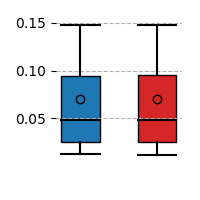

In [9]:
fig = pyplot.figure(figsize=(2,2))
axes = data.components[1].box_plot(axes = fig.add_subplot(111),
                                   pos = 0,
                                   extrema = False,
                                   color = 'b')
axes = data.components[3].box_plot(axes = axes,
                                   pos = 1,
                                   extrema = False,
                                   color = 'r')
pyplot.tight_layout()
axes.xaxis.set_visible(False)
axes.yaxis.grid(True, linestyle='--')
axes.set_frame_on(False)
fig.savefig('pi_' + str(alpha) + '-' + str(observations) + '.' + figure)